### Una simple prueba de k-means con scikit-learn.
Los datos (dos variables) se cargan desde un archivo CSV.

In [1]:
# inicializaciones
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
# Datos: leyendo un archivo CSV (creado por 00-gen2Ddata.ipynb)
D = pd.read_csv('dataS11.csv', sep=';', header=None)
print(D.describe())
X = np.array(D)

                0           1
count  200.000000  200.000000
mean     3.119035   -0.382835
std      5.395644    3.137519
min     -6.874860   -7.075802
25%      0.311461   -2.922907
50%      4.256648   -0.710461
75%      6.582249    2.412043
max     11.359325    5.753062


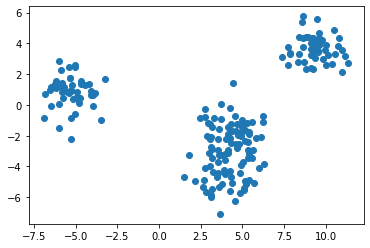

In [3]:
# Muestra los datos
# Plot
plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
# k-means:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [5]:
# Calcula los valores en los puntos de una cuadrícula 2D (malla)
h = .1     # punto en la malla [x_min, x_max] x [y_min, y_max].

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# Generar una cuadrícula de pasos.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# etiquetas de puntos de grilla
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
print(Z.shape)

(149, 203)


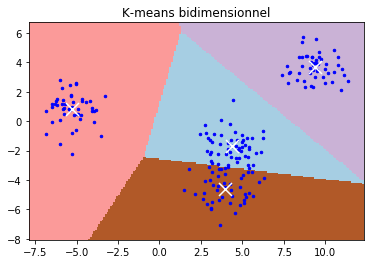

In [6]:
# Muestra
plt.figure(1)
plt.clf()
# Mostrar los puntos de la cuadrícula, como una imagen (interpolación) que da el color de fondo.
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
# Añade los puntos
plt.plot(X[:, 0], X[:, 1], 'b.', markersize=5)
# Muestra los centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means bidimensionnel')
plt.show()

### Inicializaciones

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from sklearn.datasets import load_sample_image
import imageio
from time import time

### Cargando la imagen a procesar.


In [8]:
img = imageio.imread('imagenS11.jpg')

### Mostrar la imagen

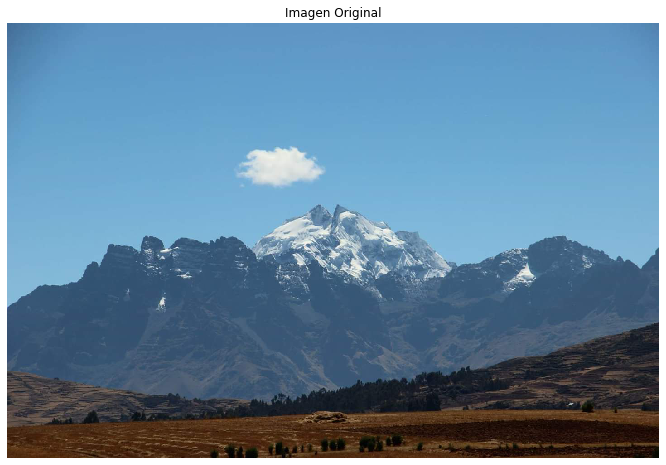

In [9]:
plt.axis('off')
plt.title('Imagen Original')
plt.imshow(img)
plt.show()

### ¿Cómo se representa la imagen?
Cada píxel es un vector (r, g, b)

La imagen es una tabla x altura x ancho x 3

In [10]:
print(type(img))
print(img.shape)
print(img[0,10]) # el décimo píxel de la línea 0

<class 'imageio.core.util.Array'>
(960, 1439, 3)
[ 65 108 151]


Convertir a flotantes en lugar de la codificación predeterminada de enteros de 8 bits. Dividiendo por 255 es importante para que plt.imshow se comporte bien en datos flotantes. estar en el rango [0-1]

In [11]:
img = np.array(img, dtype=np.float64) / 255

w, h, d = img.shape
assert d == 3 # solo procesar imagen en color RGB
image_array = img.reshape(w * h, d) # Una matriz de píxeles, sin una estructura 2D.
print(image_array.shape)

(1381440, 3)


### ¿Cuántos colores distintos?
Ejemplo de uso de la función unique:

In [12]:
A = np.array( [ (0,0,0), (1,1,1), (1,2,3), (0,0,0)])
print(A)
print('Unico: \n', np.unique(A, axis=0))

[[0 0 0]
 [1 1 1]
 [1 2 3]
 [0 0 0]]
Unico: 
 [[0 0 0]
 [1 1 1]
 [1 2 3]]


In [13]:
print('Hay', len(np.unique(image_array, axis=0)), 'colores distintos sobre', w*h, 'pixels' )

Hay 51847 colores distintos sobre 1381440 pixels


### Cuantificación
Cuantificación es una técnica de compresión con pérdida que consiste en agrupar todo un rango de valores en uno solo. Si cuantificamos el color de una imagen, reducimos el número de colores necesarios para representarla y el tamaño del fichero de la misma disminuye. Esto es importante, por ejemplo, para representar una imagen en dispositivos que sólo dan soporte a un número limitado de colores.

La función pairwise_distances_argmin https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html#sklearn.metrics.pairwise_distances_argmin calcula los índices de los puntos más cercanos.

### tomar N colores al azar (elegimos N píxeles aleatorios de la imagen):

In [14]:
n_colors = 16 # N
codebook_random = shuffle(image_array, random_state=0)[:n_colors]

### Aplica este codificador a la imagen:


In [15]:
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print("hecho en %0.3fs." % (time() - t0))

hecho en 0.642s.


(-0.5, 1438.5, 959.5, -0.5)

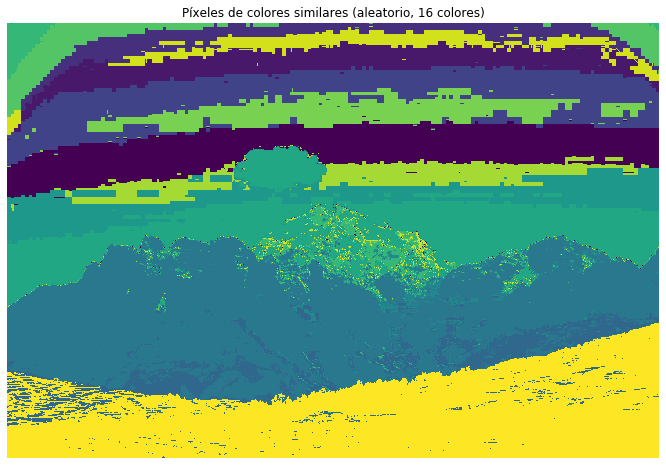

In [16]:
plt.imshow(labels_random.reshape(w, h))
plt.title('Píxeles de colores similares (aleatorio,% d colores)' % n_colors)
plt.axis('off')

### Función que recrea una imagen de las etiquetas del libro de códigos.

In [17]:
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

### Imagen cuantificada construida.

In [18]:
img_q_random = recreate_image(codebook_random, labels_random, w, h)


### Mostrar el resultado

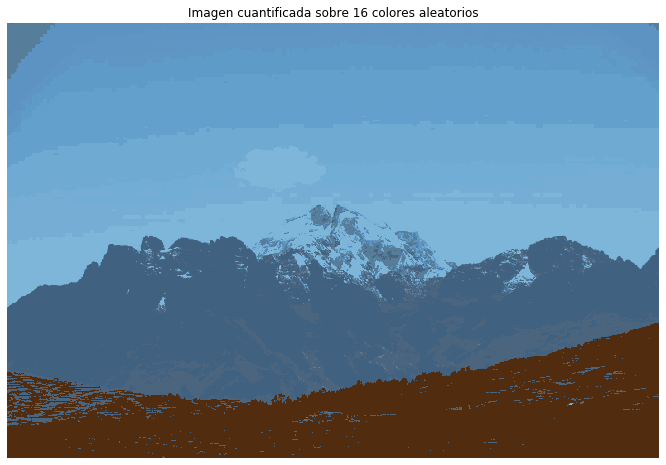

In [19]:
plt.axis('off')
plt.title('Imagen cuantificada sobre %d colores aleatorios' % n_colors)
plt.imshow(img_q_random)
plt.show()

### Cuantificacion con k-means
Vamos a cuantificar el color de la imagen siguiente utilizando k-means.

In [20]:
print("Ajuste del modelo en una pequeña sub-muestra de los datos.")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("hecho en %0.3fs." % (time() - t0))

Ajuste del modelo en una pequeña sub-muestra de los datos.
hecho en 0.305s.


### Consigue etiquetas para todos los puntos

In [21]:
print("Predicción de índices de color en la imagen completa (k-medias)")
t0 = time()
labels_kmeans = kmeans.predict(image_array)
print("hecho en %0.3fs." % (time() - t0))

Predicción de índices de color en la imagen completa (k-medias)
hecho en 0.537s.


(-0.5, 1438.5, 959.5, -0.5)

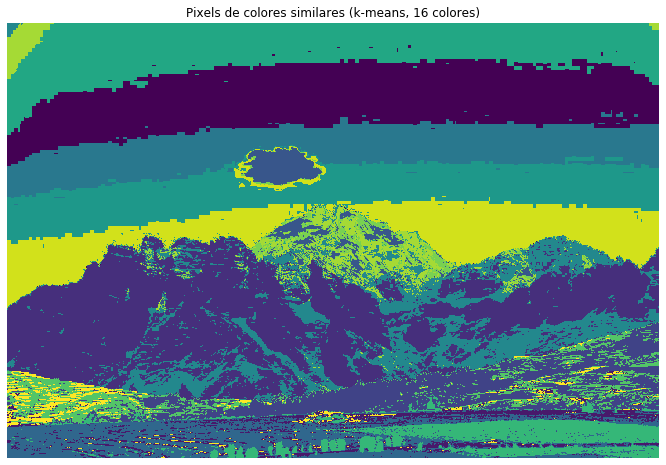

In [22]:
plt.imshow(labels_kmeans.reshape(w, h))
plt.title('Pixels de colores similares (k-means, %d colores)' % n_colors)
plt.axis('off')

A partir de las etiquetas y los colores (intensidades de rojo, verde y azul) de los centroides reconstruimos la matriz de la imagen utilizando únicamente los colores de los centroides.

### Imagen cuantificada construida.

In [23]:
img_q_kmeans = recreate_image(kmeans.cluster_centers_, labels_kmeans, w, h)

### Mostrar el resultado

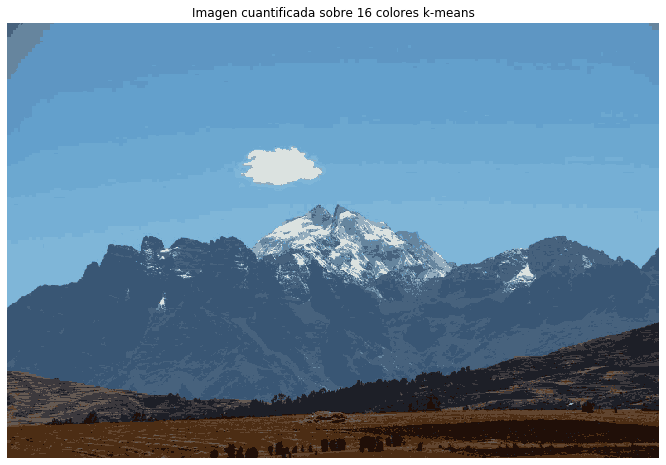

In [24]:
plt.axis('off')
plt.title('Imagen cuantificada sobre %d colores k-means' % n_colors)
plt.imshow(img_q_kmeans)
plt.show()

### Mostrando tres imágenes lado a lado

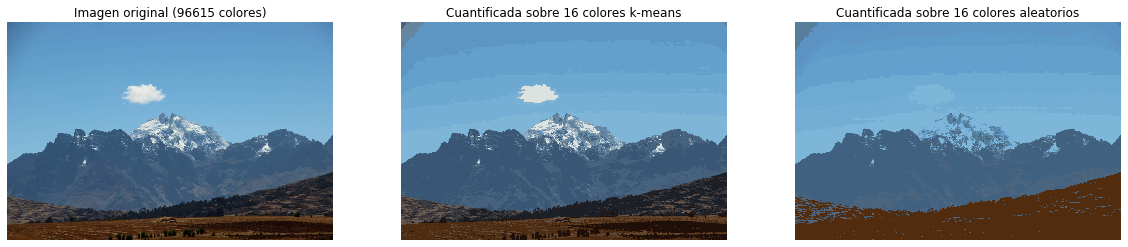

In [25]:
plt.figure(figsize=(20,4))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Imagen original (96615 colores)')
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Cuantificada sobre %d colores k-means' % n_colors)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels_kmeans, w, h))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Cuantificada sobre %d colores aleatorios' % n_colors)
plt.imshow(recreate_image(codebook_random, labels_random, w, h))

plt.show()